# 1. Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import re
import random
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Read Data
df = pd.read_csv('IMDB Dataset.csv', header=0, skiprows=lambda i: i>0 and random.random() > 0.05)
df.shape

(2518, 2)

# 2. Exploratory Data Analysis

In [3]:
# First 5 entries
df.head()

,review,sentiment
0,If you like original gut wrenching laughter yo...,positive
1,It had all the clichés of movies of this type ...,negative
2,The 33 percent of the nations nitwits that sti...,negative
3,"Nicholas Walker is Paul, the local town Revera...",negative
4,This tale based on two Edgar Allen Poe pieces ...,positive


In [4]:
# Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     2518 non-null   object
 1   sentiment  2518 non-null   object
dtypes: object(2)
memory usage: 39.5+ KB


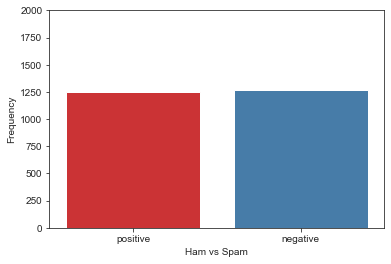

Percentage of positive reviews:  49.7 %
Percentage of negative reviews: 50.3 %


In [5]:
# Lets create a barchart of the response variable
sns.set_style('ticks')
sns.countplot(data=df, x="sentiment", order=["positive", "negative"], palette='Set1')
plt.xlabel('Ham vs Spam')
plt.ylabel('Frequency')
plt.ylim([0, 2000])
plt.show()


# Proportion of positive vs negative reviews
x = df['sentiment'].value_counts(normalize=True)
print("Percentage of positive reviews: ", str(x['positive'].round(3) * 100), '%')
print("Percentage of negative reviews:", str(x['negative'].round(3) * 100), '%')

# 3. Data Preprocessing

I will perform the following preprocessing techniques:

- Replace everything that is not a letter with a blank space
- Replace html tags with a space
- Lowercase all letters
- Store each word seperately in a list
- Lemmatize words and remove stop words
- One-Hot encoding
- Binary encoding target variable
- Removing stopwords

In [6]:
corpus = []
for i in range(len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df.review[i]) 
    review = re.sub('<br /><br />', ' ', review) 
    review = re.sub('br    br', ' ', review) 
    review = review.lower()
    review = review.split() 
    lem = WordNetLemmatizer() # Instantiate Porter Stemmer
    review = [lem.lemmatize(word) for word in review if word not in set(stopwords.words('english'))] # Stem words
    review = ' '.join(review) # join the stemmed words back to review
    corpus.append(review) # add sentences to the corpus 

In [7]:
# Vocabulary Size 
voc = 10000

In [8]:
# One hot encoding
ohe = [one_hot(words, voc) for words in corpus]

In [9]:
# One Hot Encode and apply padding
sent_length = 500
embed = pad_sequences(ohe, padding = 'pre', maxlen=sent_length)

In [10]:
# Binary encode the target variable
df["sentiment"] = df["sentiment"].replace({"positive": 1, "negative": 0})

X = np.array(embed)
y = np.array(df.sentiment)

In [11]:
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

# 4. Modelling

**1. LSTM based Recurrent Neural Network**

In [12]:
# Modelling
emb_dim=40
model = Sequential()
model.add(Embedding(voc, emb_dim, input_length = sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation = 'sigmoid'))

In [13]:
# Modelling
emb_dim=40
model = tf.keras.Sequential([Embedding(voc, emb_dim, input_length = sent_length),
        tf.keras.layers.LSTM(100),
        tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [14]:
# Optimizer, metrics and loss function
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 40)           400000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs =10,
                    batch_size=32)

Epoch 1/10
63/63 [==============================] - 5s 33ms/step - loss: 0.6917 - accuracy: 0.5571 - val_loss: 0.6771 - val_accuracy: 0.5575
Epoch 2/10
63/63 [==============================] - 2s 26ms/step - loss: 0.5188 - accuracy: 0.7572 - val_loss: 0.4920 - val_accuracy: 0.7659
Epoch 3/10
63/63 [==============================] - 2s 27ms/step - loss: 0.2071 - accuracy: 0.9275 - val_loss: 0.5312 - val_accuracy: 0.7976
Epoch 4/10
63/63 [==============================] - 2s 27ms/step - loss: 0.0738 - accuracy: 0.9791 - val_loss: 0.6748 - val_accuracy: 0.7718
Epoch 5/10
63/63 [==============================] - 2s 26ms/step - loss: 0.0267 - accuracy: 0.9935 - val_loss: 0.7582 - val_accuracy: 0.7798
Epoch 6/10
63/63 [==============================] - 2s 27ms/step - loss: 0.0109 - accuracy: 0.9980 - val_loss: 0.8674 - val_accuracy: 0.7738
Epoch 7/10
63/63 [==============================] - 2s 27ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 1.0002 - val_accuracy: 0.7698
Epoch 8/10
63

In [16]:
# Predictions
y_pred = np.squeeze(model.predict(X_test).round())

# Accuracy
acc = accuracy_score(y_test, y_pred).round(3)
print("RNN-LSTM Accuracy:", acc * 100, '%')

RNN-LSTM Accuracy: 78.4 %


In [17]:
# Confusion Matrix & Classification Report

def evaluate_model(model, X_test):
    
    y_pred = np.squeeze(model.predict(X_test).round())
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=["Ham", "Spam"])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.6, labels=["positive", "negative"])
    plt.yticks(ticks=np.arange(2) + 0.6, labels=["positive", "negative"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Testing Accuracy:", accuracy_score(y_test, y_pred).round(3) * 100, "%")
    print("\nClassification Report for LSTM-RNN :\n----------------------------------\n", clr)

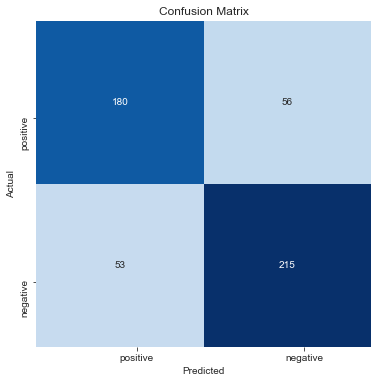

Testing Accuracy: 78.4 %

Classification Report for LSTM-RNN :
----------------------------------
               precision    recall  f1-score   support

         Ham       0.77      0.76      0.77       236
        Spam       0.79      0.80      0.80       268

    accuracy                           0.78       504
   macro avg       0.78      0.78      0.78       504
weighted avg       0.78      0.78      0.78       504



In [18]:
evaluate_model(model, X_test)

**2. Bi-Directional LSTM based RNN**

In [19]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(voc, emb_dim,input_length = sent_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation = 'relu'),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [20]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 40)           400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               53760     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 462,081
Trainable params: 462,081
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs =10,
          batch_size=64)

Epoch 1/10
32/32 [==============================] - 4s 66ms/step - loss: 0.6921 - accuracy: 0.5412 - val_loss: 0.6863 - val_accuracy: 0.6369
Epoch 2/10
32/32 [==============================] - 2s 48ms/step - loss: 0.6383 - accuracy: 0.7279 - val_loss: 0.6117 - val_accuracy: 0.7321
Epoch 3/10
32/32 [==============================] - 2s 47ms/step - loss: 0.2921 - accuracy: 0.9071 - val_loss: 0.4535 - val_accuracy: 0.7956
Epoch 4/10
32/32 [==============================] - 1s 46ms/step - loss: 0.0845 - accuracy: 0.9737 - val_loss: 0.5820 - val_accuracy: 0.7956
Epoch 5/10
32/32 [==============================] - 1s 47ms/step - loss: 0.0231 - accuracy: 0.9960 - val_loss: 0.6904 - val_accuracy: 0.8016
Epoch 6/10
32/32 [==============================] - 1s 46ms/step - loss: 0.0130 - accuracy: 0.9985 - val_loss: 0.7638 - val_accuracy: 0.7917
Epoch 7/10
32/32 [==============================] - 1s 46ms/step - loss: 0.0109 - accuracy: 0.9985 - val_loss: 0.7847 - val_accuracy: 0.8095
Epoch 8/10
32

In [23]:
# Predictions
y_pred = np.squeeze(model.predict(X_test).round())

# Accuracy
acc = accuracy_score(y_test, y_pred).round(3)
print("Bi-Directional RNN Accuracy:", acc * 100, '%')

Bi-Directional RNN Accuracy: 79.4 %


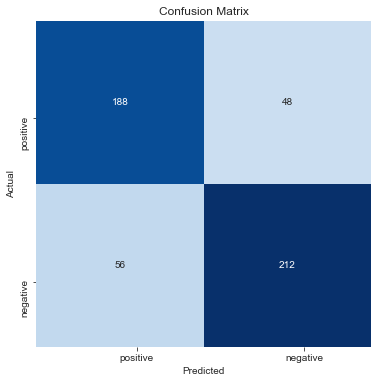

Testing Accuracy: 79.4 %

Classification Report for LSTM-RNN :
----------------------------------
               precision    recall  f1-score   support

         Ham       0.77      0.80      0.78       236
        Spam       0.82      0.79      0.80       268

    accuracy                           0.79       504
   macro avg       0.79      0.79      0.79       504
weighted avg       0.79      0.79      0.79       504



In [24]:
evaluate_model(model, X_test)

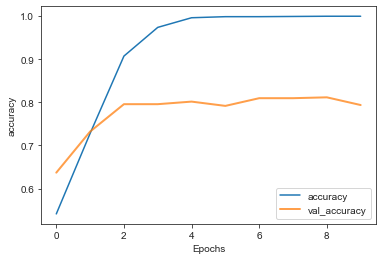

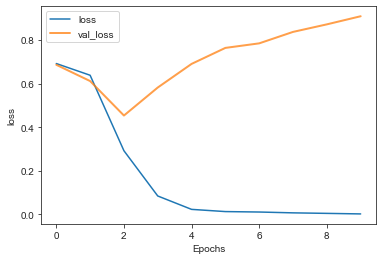

In [25]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], linewidth = 2, alpha = 0.75)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")